In [4]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
from pycqed.analysis_v2 import base_analysis as ba
from pycqed.analysis import measurement_analysis as ma
from pycqed.analysis import analysis_toolbox as a_tools
from IPython.display import clear_output 

a_tools.datadir = "Q:\\USERS\\nathan\\data"
ba.BaseDataAnalysis.get_default_plot_params()

{'figure.figsize': (10, 6.180339887498948),
 'figure.dpi': 300,
 'savefig.dpi': 300,
 'font.size': 18,
 'figure.titlesize': 18,
 'legend.fontsize': 18,
 'axes.labelsize': 18,
 'axes.labelcolor': 'k',
 'axes.titlesize': 18,
 'axes.linewidth': 1,
 'lines.markersize': 6,
 'lines.linewidth': 2.5,
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'xtick.labelsize': 18,
 'ytick.labelsize': 18,
 'xtick.color': 'k',
 'ytick.color': 'k',
 'xtick.major.size': 5,
 'ytick.major.size': 5,
 'xtick.major.width': 1,
 'ytick.major.width': 1,
 'axes.formatter.useoffset': False}

In [5]:
def get_parameters(timestamp, all=True, gammas=False, betas=False, iteration=False, Cs=False,
                        energy=False, correlations=False, states_filtered=False):
    """
    Get relevant parameters from the measurement file. 'all' overrides all other parameters except 
        states filtered which has to be activated manually because it loads a lot of data.
    
    """
    params = {"timestamp": t}
    a = ma.MeasurementAnalysis(timestamp=timestamp, auto=False)
    if all:
        gammas, betas, iteration, energy, correlations = [True]*5
    if gammas:
        params["gammas"] = list(a.data_file["Experimental Data"]["Experimental Metadata"]['gammas'])
    if betas:
        params["betas"] = list(a.data_file["Experimental Data"]["Experimental Metadata"]['betas'])
    if iteration:
        params["iteration"] = a.data_file["Experimental Data"]["Experimental Metadata"].attrs['iteration']
    if energy:
        params["energy"] = a.data_file['Analysis']['Processed data']['analysis_params_dict'].attrs['energy']
    if correlations:
        params["correlations"] = {n:v for n, v in zip(
            a.data_file['Analysis']['Processed data']['correlations'].attrs['names'],
            a.data_file['Analysis']['Processed data']['correlations']['values'])}
    if states_filtered:
        params["states_filtered"] = a.data_file['Analysis']['Processed data']["qb_states_filtered"]
    if Cs:
        raise NotImplementedError()
    return params

def get_parameters_run(timestamps, **kwargs):
    
    b, g, e, c, it, s = [],[],[],[], [], []
    for t in timestamps:
        params = get_parameters(t, **kwargs)
        b.append(params.get("betas", np.nan))
        g.append(params.get("gammas", np.nan))
        it.append(params.get('iteration', np.nan))
        e.append(params.get('energy', np.nan))
        c.append(params.get('correlations', np.nan))
        s.append(params.get("qb_states_filtered", np.nan))

    params_run = {}
    params_run['betas'] = np.asarray(b)
    params_run['gammas'] = np.asarray(g)
    params_run['iterations'] = np.asarray(it)
    params_run["energy"] = np.asarray(e)
    params_run["correlations"] = np.asarray(c)
    params_run["iteration_mask"] = np.asarray([e == np.amin(e[it == i]) 
                                   for i in range(max(it)+1)])
    params_run["timestamps"] = timestamps
    return params_run

def get_parameters_runs(tstart, tend, **kwargs):
    #check for label name in case interleaved tomography
    tps = a_tools.get_timestamps_in_range(tstart, tend, label="QAOA") 
    fevals = np.array([eval(a_tools.get_folder(t).split("_")[-1]) for t in tps])
    n_all_files = -np.diff(np.pad(fevals, (0,1), 'constant'))[np.diff(np.pad(fevals, (0,1), 'constant')) != 1] + 1
    all_run_params = []
    for i, nfiles in enumerate(n_all_files):
        print(tps[np.sum(n_all_files[:i])])
#         print(len(tps))
        print(tps[np.sum(n_all_files[:i]) + nfiles-1])
#         print(n_all_files)
        tmps = a_tools.get_timestamps_in_range(tps[np.sum(n_all_files[:i])], 
                                               tps[np.sum(n_all_files[:i]) + nfiles-1])
        all_run_params.append(get_parameters_run(tmps, **kwargs))
    return all_run_params

def qaoa_propagator(n_qbs, two_qb_pairs, gammas, betas, Cs, hs):
    q = QubitCircuit(n_qbs, reverse_states=False)
    qubits = np.arange(n_qbs)

    assert len(Cs) == len(two_qb_pairs), f"Cs and two_qb_pairs do not match: {len(Cs) } vs {len(two_qb_pairs)}"
    
    # init
    for qb in qubits:
        q.add_gate("RY", targets=qb, arg_value=np.pi/2, arg_label=r'\frac{\pi}{2}')

    for g, b in zip(gammas, betas):
        for C, pair in zip(Cs, two_qb_pairs):
            q.add_gate("RZ", targets=pair[0], arg_value=-2*g*C, arg_label=r'-2\gamma C')
            q.add_gate("RZ", targets=pair[1], arg_value=-2*g*C, arg_label=r'-2\gamma C')
            q.add_gate("CPHASE", controls=pair[0], targets=pair[1], arg_value=(4*g*C) % (2*np.pi), arg_label=r'4\gamma C')
        for k,h in enumerate(hs):
            q.add_gate("RZ", targets=[k], arg_value=2*g*h, arg_label=r'-2\gamma C')

        # D
        for qb in qubits:
            q.add_gate("RX", targets=qb, arg_value=b, arg_label=r'\beta')

    U_list = q.propagators()
    return gate_sequence_product(U_list)

def cs_to_phys(labels):
    """
    changes list of labels '[0 1 0]' --> '$|010\rangle$'
    """
    labels = [str(l) for l in labels]
    return ["$|{}\\rangle$".format(l.translate({ord(i): None for i in '[() ],'})) 
            for l in labels]
    
def bar_plot(timestamp, gammas=None, betas=None, Cs=None, hs=None, 
             two_qb_pairs='linear_array', correct_states=None, plot=True, 
             expected_state=None,
             save=False):
    """
    Creates histogram bar plot of measured states.
    Correct state formart: [b1 b2 ... bn]
    """
    results = {}
    
    # get qb states and parameters
    a = ma.MeasurementAnalysis(timestamp=timestamp, auto=False)
    states = np.asarray(a.data_file['Analysis']["Processed data"]["qubit_states"])
    results['states'] = states
    n_qbs = states.shape[1]
    qubits = np.arange(n_qbs)
    try:
        if gammas is None:
            gammas = a.data_file["Experimental Data"]["Experimental Metadata"]['gammas']
        if betas is None:
            betas = a.data_file["Experimental Data"]["Experimental Metadata"]['betas']
    except TypeError:
        gammas = [eval(a.data_file["Experimental Data"]["Experimental Metadata"]['gammas'])]
        betas = [eval(a.data_file["Experimental Data"]["Experimental Metadata"]['betas'])]
    
    results["depth"] = len(gammas)
    # counts for each label
    states_labels, counts = np.unique(states, axis=0, return_counts=True)
    states_labels = np.array(cs_to_phys([str(s) for s in states_labels]))
    filter = [True if not "2" in s else False for s in states_labels]
    if correct_states is not None:
        correct_states = cs_to_phys(correct_states)
        counts_in_subspace = np.sum(counts[filter])
        success_prob = np.sum([counts[states_labels == c] for c in correct_states]) / counts_in_subspace
        results["success_prob"] = success_prob
        
    #qutip computation of expected state
    if Cs is None:
        _, Cs = qaoa.QAOAHelper.get_corr_and_coupl_info(
            eval(a.data_file["Experimental Data"]["Experimental Metadata"].attrs['two_qb_gates_info']))
    if hs is None:
        hs = [0 for _ in range(n_qbs)]
    if two_qb_pairs == "linear_array":
        two_qb_pairs = [(i,j) for i,j in zip(qubits, qubits[1:]) ] 
    else:
        raise NotImplementedError()
        
    U = qaoa_propagator(n_qbs, two_qb_pairs, gammas, betas, Cs, hs)
    H = U * ket("0"*len(qubits))
    results['expected_state'] = np.real((H*H.dag()).full()[np.eye(len(H.full()), dtype=bool)])
    results["expected_state_labels"] = np.array(cs_to_phys(list(itertools.product((0,1), repeat=n_qbs))))
    if correct_states is not None:
        success_prob_theory = np.sum([results['expected_state'][results["expected_state_labels"] == c] for c in correct_states])
        results['success_prob_theory'] = success_prob_theory
        
    if plot:
        fig, ax = plt.subplots()
        order = list(reversed(np.argsort(counts[filter])))
        expected_state_labels_in_mmnt = [True if sl in states_labels[filter][order] else False for sl in results["expected_state_labels"]]
        ax.bar(states_labels[filter][order], counts[filter][order]/np.sum(counts[filter]),
              color='grey')
        ax.bar(results["expected_state_labels"][expected_state_labels_in_mmnt] , results['expected_state'][expected_state_labels_in_mmnt], 
               fill=False, linewidth=1, edgecolor='k', 
               label="$P_s$ noise-free sim.: {:.3f}".format(success_prob_theory))
        if correct_states is not None:
            correct_states_counts = np.asarray([counts[states_labels == c]/np.sum(counts[filter]) for c in correct_states])
            
            ax.bar(correct_states, correct_states_counts.flatten() , 
                   color='green', label="$P_s$: {:.3f}".format(success_prob))
            ax.legend()
        plt.xticks(states_labels[filter],  rotation='vertical')
        ax.set_ylabel("Fraction of measurements (arb. u.)")

        results['fig'] = fig
        if save:
            fig.tight_layout()
            fig.savefig(a.folder + "\\bit_strings_frequency.png")
            
    return results

# Simulator Class

In [7]:
# two qb pulse
class Simulator:
    STD_INIT = {'0': [], 
                '1': [{"operation": 'RX', "arg_value": np.pi, "arg_label": r'\pi'}], 
                '+': [{"operation": 'RY', "arg_value": np.pi/2, "arg_label": r'\frac{\pi}{2}'}], 
                '-': [{"operation": 'RY', "arg_value": -np.pi/2, "arg_label": r'-\frac{\pi}{2}'}]}
    
    def __init__(self, qubits, single_qb_pulse_type="square"):
        self.qubits = qubits
        self.circ = QubitCircuit(len(qubits))
        self.single_qb_pulse_type  = single_qb_pulse_type
        self.two_qb_pulses = []
        self.single_qb_pulses = []
        self.Ht = []
        self.tnext = {qb:0 for qb in qubits}
        self.GATES = {"I":self.i, 'RX':self.rx, 'RY':self.ry, 'RZ':self.rz, 'CPHI':self.cphi}
        self.random_seed = 0
#         if alpha_zzs is None:
#             self.H_alpha_zz = self.identity() - self.identity() # no alpha zz
#         else:
#             self.H_alpha_zz = self.alpha_zz(alpha_zzs, order) 
        np.random.seed(self.random_seed)
    
    @staticmethod
    def square_pulse(t, qubit, args=None):
        tstart = args[qubit]["tstart"]
        length = 1/args[qubit]["amplitude"]*args[qubit]["angle"]/pi
        if t < tstart:
            return 0
        elif tstart < t <= tstart + length:
            return 1
        else:
            return 0 
    
    def get_qubits(self, qubits='all'):
        """
        Wrapper to get 'all' qubits, single qubit specified as string
        or list of qubits, checking they are in self.qb_names
        :param qubits: 'all', single qubit name (eg. 'qb1') or list of qb names
        :return: list of qb names or their indices 
        """
        if qubits == 'all':
            return self.qubits
        elif qubits in self.qubits:  # qubits == single qb name eg. 'qb1'
             qubits = [qubits]
        for qb in qubits:
            assert qb in self.qubits, f"{qb} not found in {self.qubits}"
            
        return qubits
    
    def add_gate(self, gate_name, *args, **kwargs):
        assert gate_name in self.GATES, f"unkown gate {gate_name}"
        return self.GATES[gate_name](*args, **kwargs)
    
    # single qubit gates
    def rx(self, length, angle=None, tstart='previous_pulse', qubits="all"):
        qbs = self.get_qubits(qubits)
        if angle is None:
            angle = [pi]*len(qbs)
        H = []
        pulse_envelopes = []
        for qb in qbs:
            H.append(pi/2*angle/pi/length*self.sx(qb))
            if tstart == "previous_pulse":
                t = self.tnext[qb]
            else:
                t = tstart
            self.single_qb_pulses.append(dict(length=length, tstart=t, angle=angle, qb=qb, type="rx"))
            self.tnext[qb] += length
            pulse_envelopes.append(self.single_qb_envelope_generator(len(self.single_qb_pulses)-1))

        hamiltonian_and_envelopes = [[h, env] for h, env in zip(H, pulse_envelopes)]
        self.Ht.extend(hamiltonian_and_envelopes)
        return hamiltonian_and_envelopes

    def ry(self, length, angle=None, tstart='previous_pulse', qubits="all"):
        qbs = self.get_qubits(qubits)
        if angle is None:
            angle = [pi]*len(qbs)
        H = []
        pulse_envelopes = []
        for qb in qbs:
            H.append(pi/2*angle/pi/length*self.sy(qb))
            if tstart == "previous_pulse":
                t = self.tnext[qb]
            else:
                t = tstart
            self.single_qb_pulses.append(dict(length=length, tstart=t, angle=angle, qb=qb, type="ry"))
            self.tnext[qb] += length
            pulse_envelopes.append(self.single_qb_envelope_generator(len(self.single_qb_pulses)-1))

        hamiltonian_and_envelopes = [[h, env] for h, env in zip(H, pulse_envelopes)]
        self.Ht.extend(hamiltonian_and_envelopes)
        return hamiltonian_and_envelopes

    def rz(self, length, angle=None, tstart='previous_pulse', qubits="all"):
        qbs = self.get_qubits(qubits)
        if angle is None:
            angle = [pi]*len(qbs)
        H = []
        pulse_envelopes = []
        for qb in qbs:
            H.append(pi/2*angle/pi/length*self.sz(qb))
            if tstart == "previous_pulse":
                t = self.tnext[qb]
            else:
                t = tstart
            self.single_qb_pulses.append(dict(length=length, tstart=t, angle=angle, qb=qb, type="rz"))
            self.tnext[qb] += length
            pulse_envelopes.append(self.single_qb_envelope_generator(len(self.single_qb_pulses)-1))

        hamiltonian_and_envelopes = [[h, env] for h, env in zip(H, pulse_envelopes)]
        self.Ht.extend(hamiltonian_and_envelopes)
        return hamiltonian_and_envelopes
    
    def i(self, length, angle=None, tstart='previous_pulse', qubits="all"):
        qbs = self.get_qubits(qubits)
        H = []
        pulse_envelopes = []
        for qb in qbs:
            H.append(self.identity() - self.identity())
            if tstart == "previous_pulse":
                t = self.tnext[qb]
            else:
                t = tstart
            self.single_qb_pulses.append(dict(length=length, tstart=t, angle=0, qb=qb, amplitude=0, type="i"))
            self.tnext[qb] += length
            pulse_envelopes.append(self.single_qb_envelope_generator(len(self.single_qb_pulses)-1))

        hamiltonian_and_envelopes = [[h, env] for h, env in zip(H, pulse_envelopes)]
        self.Ht.extend(hamiltonian_and_envelopes)
        return hamiltonian_and_envelopes
    
    # single qubit envelopes
    def single_qb_envelope_generator(self, pulse_index): 
        if self.single_qb_pulse_type == "square":
            def square_pulse(t, args=None):
                pulse = self.single_qb_pulses[pulse_index]
                tstart = pulse["tstart"]
                angle = pulse["angle"]
                length = pulse['length']
                amplitude = pulse.get("amplitude", 1) 
                if t < tstart:
                    return 0
                elif tstart < t <= tstart + length:
                    return amplitude
                else:
                    return 0 
            return square_pulse
        elif self.single_qb_pulse_type == "gaussian":
            def gaussian_pulse(t, args=None):
                qubit = self.qubits[qb_index]
                tstart = args[qubit]["tstart"]
                nsigma = args[qubit]["ge_nr_sigma"]
                sigma = args[qubit]['ge_sigma']
                amplitude = args[qubit]["amplitude"]
                length = sigma*nr_sigma #1/amplitude * args[qubit]["angle"]/pi
                mu = length / 2 + tstart
                if t < tstart:
                    return 0
                elif tstart < t <= tstart + length:
                    return amplitude * np.exp(-(0.5 * ((t - mu)**2) / sigma**2))
                else:
                    return 0 
            return square_pulse
        
    # two qubit gates
    def cphi(self, qubit_pair, arb_phase_func, phi=pi, tstart="previous_pulse", 
             buffer_start=0.015, buffer_end=0.015, gate_error_std=0):
        qbs = self.get_qubits(qubit_pair)
        tnext = np.amax([self.tnext[qb] for qb in qbs])
        buffers_start = self.add_gate("I", length=buffer_start, tstart=tnext, qubits=qbs)
        Hcphi = 1/4 * (2*pi-phi) * (self.identity() -self.sz(qubit_pair[0])  - self.sz(qubit_pair[1]) + 
                  self.sz(qubit_pair[0])  * self.sz(qubit_pair[1]) )
        
#         H =  Qobj([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,phi]])
#         H.dims = [[2, 2], [2, 2]]
        amplitude, length = eval(arb_phase_func)(phi)
        if tstart == 'previous_pulse':
            tstart = self.tnext[qbs[0]]
            
        tnext = np.amax([self.tnext[qb] for qb in qbs])
        for qb in qbs:
            self.tnext[qb] = tnext + length 

        pulse_params = dict(tstart=tstart, length=length, amplitude=amplitude)
        pulse_envelope = self.Cphi_envelope_generator(len(self.two_qb_pulses))
        self.two_qb_pulses.append(pulse_params)
        self.Ht.append([Hcphi, pulse_envelope]) # correct hamiltonian by alpha zz
        
        buffers_end = self.add_gate("I", length=buffer_end, qubits=qbs)
        return [buffers_start, [Hcphi, pulse_envelope], buffers_end]

    def Cphi_envelope_generator(self, pulse_index):
        def Cphi_envelope(t, args=None):
            pulse = self.two_qb_pulses[pulse_index]
            tstart = pulse["tstart"]
            length = pulse["length"]
            amplitude = pulse["amplitude"]
            if t < tstart:
                return 0
            elif tstart < t <= tstart + length:
                return amplitude
            else:
                return 0 
        return Cphi_envelope
    
    # operators
    def sz(self, qubit):
        return tensor(*(sigmaz() if qb == qubit else identity(2) for qb in self.qubits))
    
    def sx(self, qubit):
        return tensor(*(sigmax() if qb == qubit else identity(2) for qb in self.qubits))
    
    def sy(self, qubit):
        return tensor(*(sigmay() if qb == qubit else identity(2) for qb in self.qubits))
    
    def sm(self, qubit):
        return tensor(*(sigmam() if qb == qubit else identity(2) for qb in self.qubits))
    
    def sp(self, qubit):
        return tensor(*(sigmap() if qb == qubit else identity(2) for qb in self.qubits))
    
    def identity(self):
        return tensor(*(identity(2) for qb in self.qubits))
    
    
    # imperfections
    # get collapse operators
    def collapse(self, t1s=None, t2s=None):
        if t1s is None:
            t1s = {}
        if t2s is None:
            t2s ={}
        c_op_list = []
        for qb, t1 in t1s.items():
            k = 1/t1
            c_op_list.append(np.sqrt(k) * self.sp(qb))
        for qb, t2 in t2s.items():
            g = (1./(t2) - 1/(2*t1))
            c_op_list.append(np.sqrt(g) * (self.sm(qb)* self.sp(qb)))

        return [[c, self.col_coeff] for c in c_op_list]
    # alpha_zz
    
    def alpha_zz(self, alpha_zzs, order=None):
        if order is None:
            order = self.qubits
        Hzzs = self.identity() - self.identity() # initialize with zeros
        for i, qb_a in enumerate(order):
            for j, qb_b in enumerate(order):
                if qb_a == qb_b:
                    continue
                Hzz = 1/4 * alpha_zzs[i,j] * (self.identity() - self.sz(qb_a)  - self.sz(qb_b) + 
                  self.sz(qb_a)  * self.sz(qb_b) )
                Hzzs += Hzz
        self.Ht.append(Hzzs)
        return Hzzs
    @staticmethod
    def col_coeff(t, args=None):  # coefficient function
        return 1
    
    def run(self, time, hamiltonian=None, initial_state='0', collapse_operators=None, args=None):
        if hamiltonian is None:
            hamiltonian = self.Ht
        if isinstance(initial_state, str) and len(initial_state) == 1:
            initial_state = ket(initial_state*len(self.qubits))
        if collapse_operators is None:
            collapse_operators = []
        if args is None:
            args = {}
#         print(Ht, initial_state, time, collapse_operators, args)
        return mesolve(Ht, initial_state, time, collapse_operators, [], args=args)

    def get_sequence_length(self):
        return np.amax([self.tnext[qb] for qb in self.qubits])

In [8]:
from pprint import pprint
def software_decomposition(qbc, qbt, sim, length, angle, arb_phase_func, buffer_start=0.015, buffer_end=0.015):
    sim.rz(sim.z_gate_length, qubits=qbt, angle=np.pi)
    sim.ry(length, qubits=qbt, angle=np.pi/2)
    sim.cphi([qbt, qbc] , arb_phase_func=arb_phase_func, phi=np.pi, buffer_start=buffer_start, buffer_end=buffer_end)
    sim.rz(sim.z_gate_length, qubits=qbt, angle=np.pi)
    sim.ry(length, qubits=qbt, angle=np.pi/2)
    sim.rz(sim.z_gate_length, qubits=qbt, angle=-2*angle)
    sim.rz(sim.z_gate_length, qubits=qbt, angle=np.pi)
    sim.ry(length, qubits=qbt, angle=np.pi/2)
    sim.cphi([qbt, qbc] , arb_phase_func=arb_phase_func, phi=np.pi, buffer_start=buffer_start, buffer_end=buffer_end)
    sim.rz(sim.z_gate_length, qubits=qbt, angle=np.pi)
    sim.ry(length, qubits=qbt, angle=np.pi/2)
    return sim
# def software_decomposition(qbc, qbt, sim, length, angle, arb_phase_func, buffer_start=0.015, buffer_end=0.015):
#     sim.rx(length, qubits=qbt, angle=np.pi)
#     sim.ry(length, qubits=qbt, angle=-np.pi/2)
#     sim.cphi([qbt, qbc] , arb_phase_func=arb_phase_func, phi=np.pi, buffer_start=buffer_start, buffer_end=buffer_end)
#     sim.rx(length, qubits=qbt, angle=np.pi)
#     sim.ry(length, qubits=qbt, angle=-np.pi/2)
#     sim.rz(sim.z_gate_length, qubits=qbt, angle=-2*angle)
#     sim.rx(length, qubits=qbt, angle=np.pi)
#     sim.ry(length, qubits=qbt, angle=-np.pi/2)
#     sim.cphi([qbt, qbc] , arb_phase_func=arb_phase_func, phi=np.pi, buffer_start=buffer_start, buffer_end=buffer_end)
#     sim.rx(length, qubits=qbt, angle=np.pi)
#     sim.ry(length, qubits=qbt, angle=-np.pi/2)
#     return sim

import itertools
def renormalize(array, subarray_shape=None, index_upper_left_corner=(0,0)):
    if subarray_shape is None:
        subarray_shape = array.shape
    a = array[index_upper_left_corner[0]:subarray_shape[0],
             index_upper_left_corner[1]:subarray_shape[1]]
    row_sums = a.sum(axis=1)
    return a / row_sums[:, np.newaxis]
def readout_correction(self, state_assignment_prob_matrices, rho=None):
    """
    state_assignment_prob_matrices (dict): key = qb name, 
        value= state assignement prob matrix, cols = assigned, rows = prepared 
    """
    M0s = {}
    M1s = {}
    sigmaz_exp = {}
    szsz_exp = {}
    e1 = basis(2,1)
    e0 = basis(2,0)
    state_prob = {}
    for qb, matrix in state_assignment_prob_matrices.items():
        pg0 = matrix[0,0]
        pe0 = matrix[0,1]
        pe1 = matrix[1,1]
        pg1 = matrix[1,0]

        M0 = np.sqrt(pg0)*e0*e0.dag() + np.sqrt(pg1)*e1*e1.dag() 
        # expand to full hilbert space
        M0s[qb] = tensor(*(M0 if qb == qubit else identity(2) for qubit in self.qubits))
        M1 = np.sqrt(pe0)*e0*e0.dag() + np.sqrt(pe1)*e1*e1.dag() 
        M1s[qb] = tensor(*(M1 if qb == qubit else identity(2) for qubit in self.qubits))
        
        if rho is not None:
            M0s[qb].dims = rho.dims
            M1s[qb].dims = rho.dims
            p0 = (M0s[qb]*rho*M0s[qb].dag()).tr()
            p1 = (M1s[qb]*rho*M1s[qb].dag()).tr() 
            sigmaz_exp[qb] = p1 - p0
    
    # sigmaz sigmaz
    for qb_pair in itertools.combinations(range(len(self.qubits)), 2):
        qb_a = self.qubits[qb_pair[0]]
        qb_b = self.qubits[qb_pair[1]]
        p00 = (M0s[qb_a] * M0s[qb_b] * rho * M0s[qb_a].dag() * M0s[qb_b].dag()).tr()
        p01 = (M0s[qb_a] * M1s[qb_b] * rho * M0s[qb_a].dag() * M1s[qb_b].dag()).tr()
        p10 = (M1s[qb_a] * M0s[qb_b] * rho * M1s[qb_a].dag() * M0s[qb_b].dag()).tr() 
        p11 = (M1s[qb_a] * M1s[qb_b] * rho * M1s[qb_a].dag() * M1s[qb_b].dag()).tr()
        szsz_exp[qb_pair] = p00 + p11 - p10 - p01
    # full matrix
    for state in itertools.product((0,1), repeat=len(self.qubits)):
        Mis = {}
        for i, qb in enumerate(self.qubits):
            Mis[qb] = M0s[qb] if state[i] == 0 else M1s[qb]
        state_prob[state] = (np.prod(list(Mis.values())) * rho  * np.prod([mi.dag() for mi in Mis.values()])).tr()
    return sigmaz_exp, szsz_exp, state_prob, M0s, M1s



# Single qubit

In [306]:
qubits = ["qb1"]
t1s = {"qb1": 16.4}
t2s = {"qb1": 25}

single_qb_pulse_length = 0.046666
psi0 = ket("1"*len(qubits))
sim = Simulator(qubits)
sim.rotation_z(0.0001, angle=0)
time = np.arange(0,50,0.0001)
print(sim.get_sequence_length(), len(time))

res = mesolve(sim.Ht, psi0, time, sim.collapse(t1s = {"qb1": 20}), [sim.sz("qb1")],
             options=Options(max_step=0.0001), progress_bar=True)


0.0001 500000
10.0%. Run time:   1.38s. Est. time left: 00:00:00:12
20.0%. Run time:   2.77s. Est. time left: 00:00:00:11
30.0%. Run time:   4.08s. Est. time left: 00:00:00:09
40.0%. Run time:   5.41s. Est. time left: 00:00:00:08
50.0%. Run time:   6.74s. Est. time left: 00:00:00:06
60.0%. Run time:   8.10s. Est. time left: 00:00:00:05
70.0%. Run time:   9.44s. Est. time left: 00:00:00:04
80.0%. Run time:  10.78s. Est. time left: 00:00:00:02
90.0%. Run time:  12.15s. Est. time left: 00:00:00:01
Total run time:  13.49s


(0, 1)

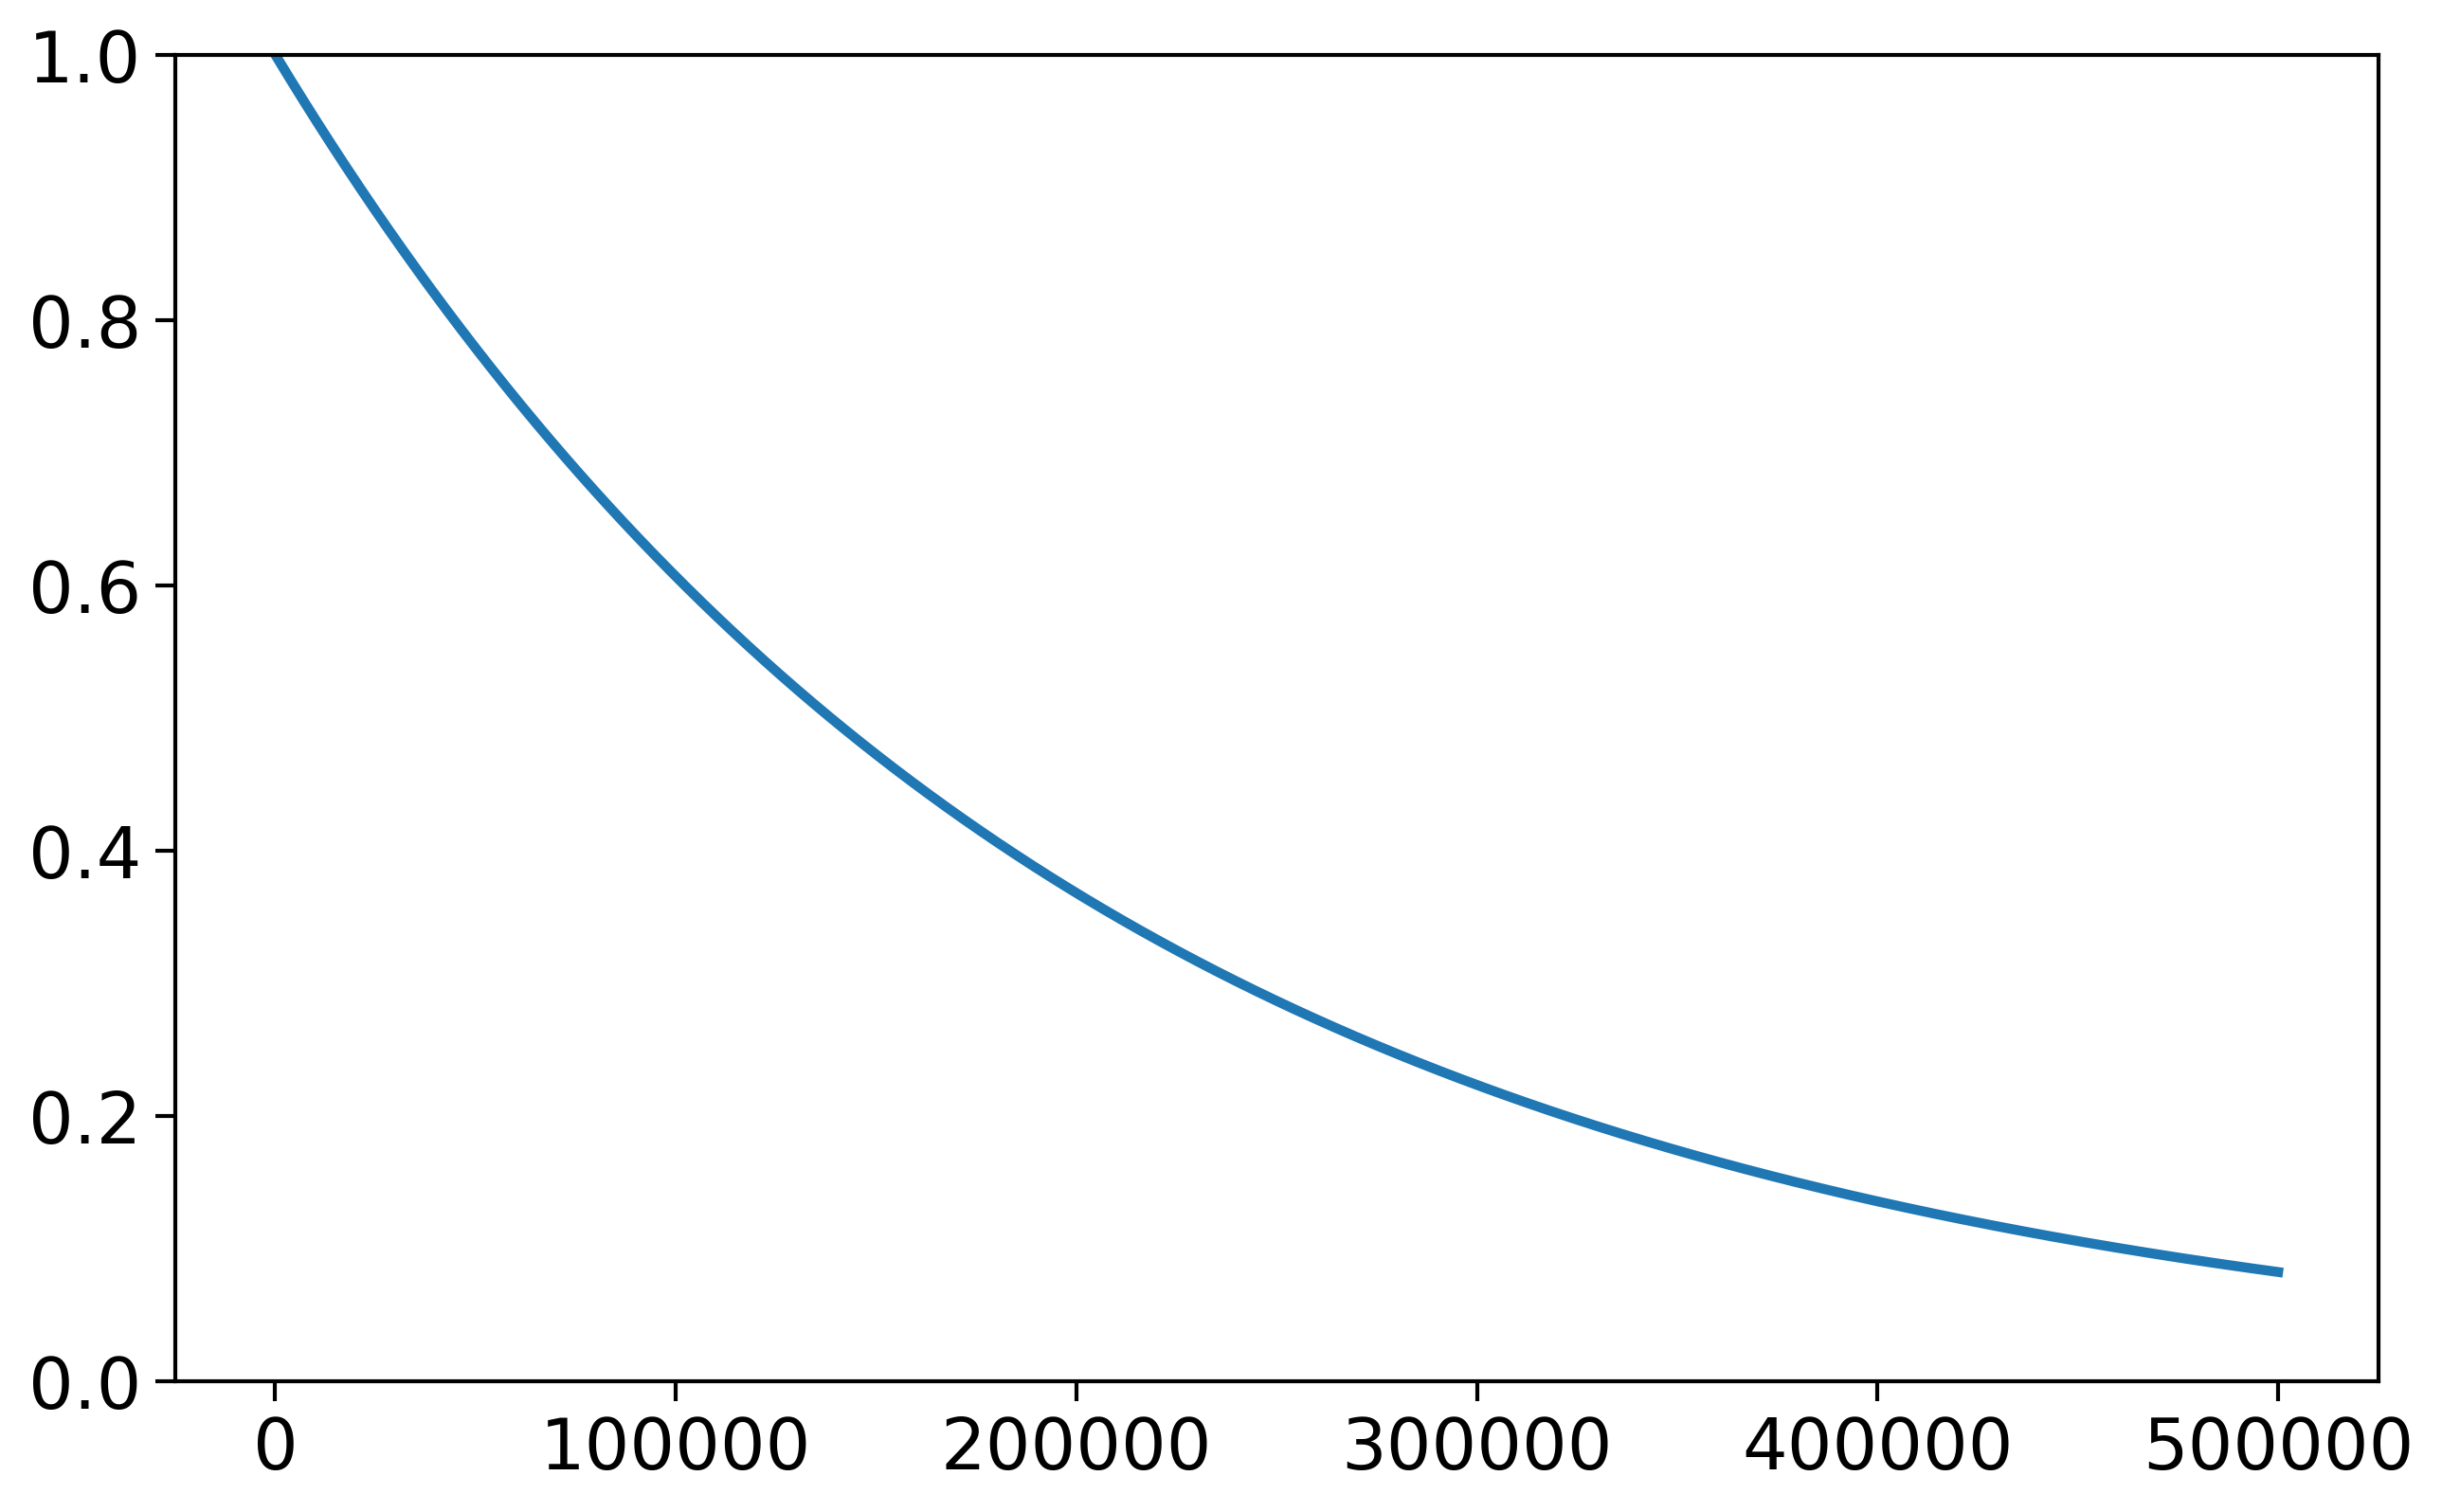

In [308]:
plt.plot((1-res.expect[0])/2)
plt.ylim([0,1])

# two qubits

## Tomography simulation

In [ ]:
a_tools.datadir = 'Q:/USERS/nathan/data/thesis_data'

In [161]:
timestamp = "20191208_151620"
a = ma.MeasurementAnalysis(timestamp=timestamp, auto=False)

effective_time = eval(a.data_file['Instrument settings/qb3'].attrs['upCZ_qb2_pulse_length']) # get effective time
time_func= eval(eval(a.data_file['Instrument settings/qb3'].attrs['upCZ_qb2_chevron_func'])) # get physical time from amp and effective time
# two_qb_gates['qb2qb3']['gate_length'] = lambda phi: cphi_length(phi, two_qb_gates['qb2qb3'])

In [175]:
# get arb phase func
timestamp = "20191209_190944"
a = ma.MeasurementAnalysis(timestamp=timestamp, auto=False)
two_qb_gates_info = eval(a.data_file['Experimental Data/Experimental Metadata'].attrs['two_qb_gates_info'])
two_qb_gates = {}
two_qb_gates['qb2qb3'] = {}
two_qb_gates['qb2qb3']['phase_func'] = \
    eval(two_qb_gates_info[0][0]['phase_func']) # for target phase get ampl required
two_qb_gates['qb2qb3']['effective_time'] = \
    eval(a.data_file['Instrument settings/qb3'].attrs['upCZ_qb2_pulse_length']) # get effective time
two_qb_gates['qb2qb3']['time_func'] = \
    eval(eval(a.data_file['Instrument settings/qb3'].attrs['upCZ_qb2_chevron_func'])) # get physical time from amp and effective time
two_qb_gates['qb2qb3']['gate_length'] = lambda phi: cphi_length(phi, two_qb_gates['qb2qb3'])


In [164]:
%matplotlib inline

In [204]:
def cphi_length(phase, gate):
    amp = gate['phase_func'](phase)[0] # get amplitude for target phase
    physical_gate_length = gate['time_func'](amp, gate['effective_time'])
#     print(physical_gate_length)
    return physical_gate_length*1e6 #rescale to timebase in micro seconds

In [196]:
angles = np.linspace(0, 2*pi, 20)


Note: Needs a 2\*pi - phi because angle in the experiment we 'think' turn from 0 to 2\*pi but in fact 0 --> -2\*pi, so 

/!\ also had to adapt cphi function in simulator such that angle also rotate in 'wrong' direction

In [202]:
qubits = ["qb2", "qb3"]
freq = {"qb1": 0, "qb2": 0}
# t1s = {"qb2": 16.9, "qb3": 16.5}
# t2s = {"qb2": 18, "qb3": 15.6}
t1s = {"qb2": 16.1, "qb3": 16}
t2s = {"qb2": 19.6, "qb3": 15.9}

# arb_phase_funcs = {"qb2qb3": "lambda phi: (1/106e-3 , 106e-3)"}
arb_phase_funcs = {"qb2qb3": "lambda phi: (1/two_qb_gates['qb2qb3']['gate_length'](phi) , two_qb_gates['qb2qb3']['gate_length'](phi))"}

U_exp = {}
for angle in angles:
    sim = Simulator(qubits)

    sim.cphi(["qb2", "qb3"], phi=angle, # need to rotate in other direction
             arb_phase_func=arb_phase_funcs['qb2qb3'], buffer_start=0.010, buffer_end=0.015)

    time = np.arange(0,sim.get_sequence_length(),0.001)
    print(sim.get_sequence_length()-0.025)
    U_exp[angle] = propagator(sim.Ht, time, 
                   sim.collapse(t1s, t2s), 
                   progress_bar=True)
    clear_output()

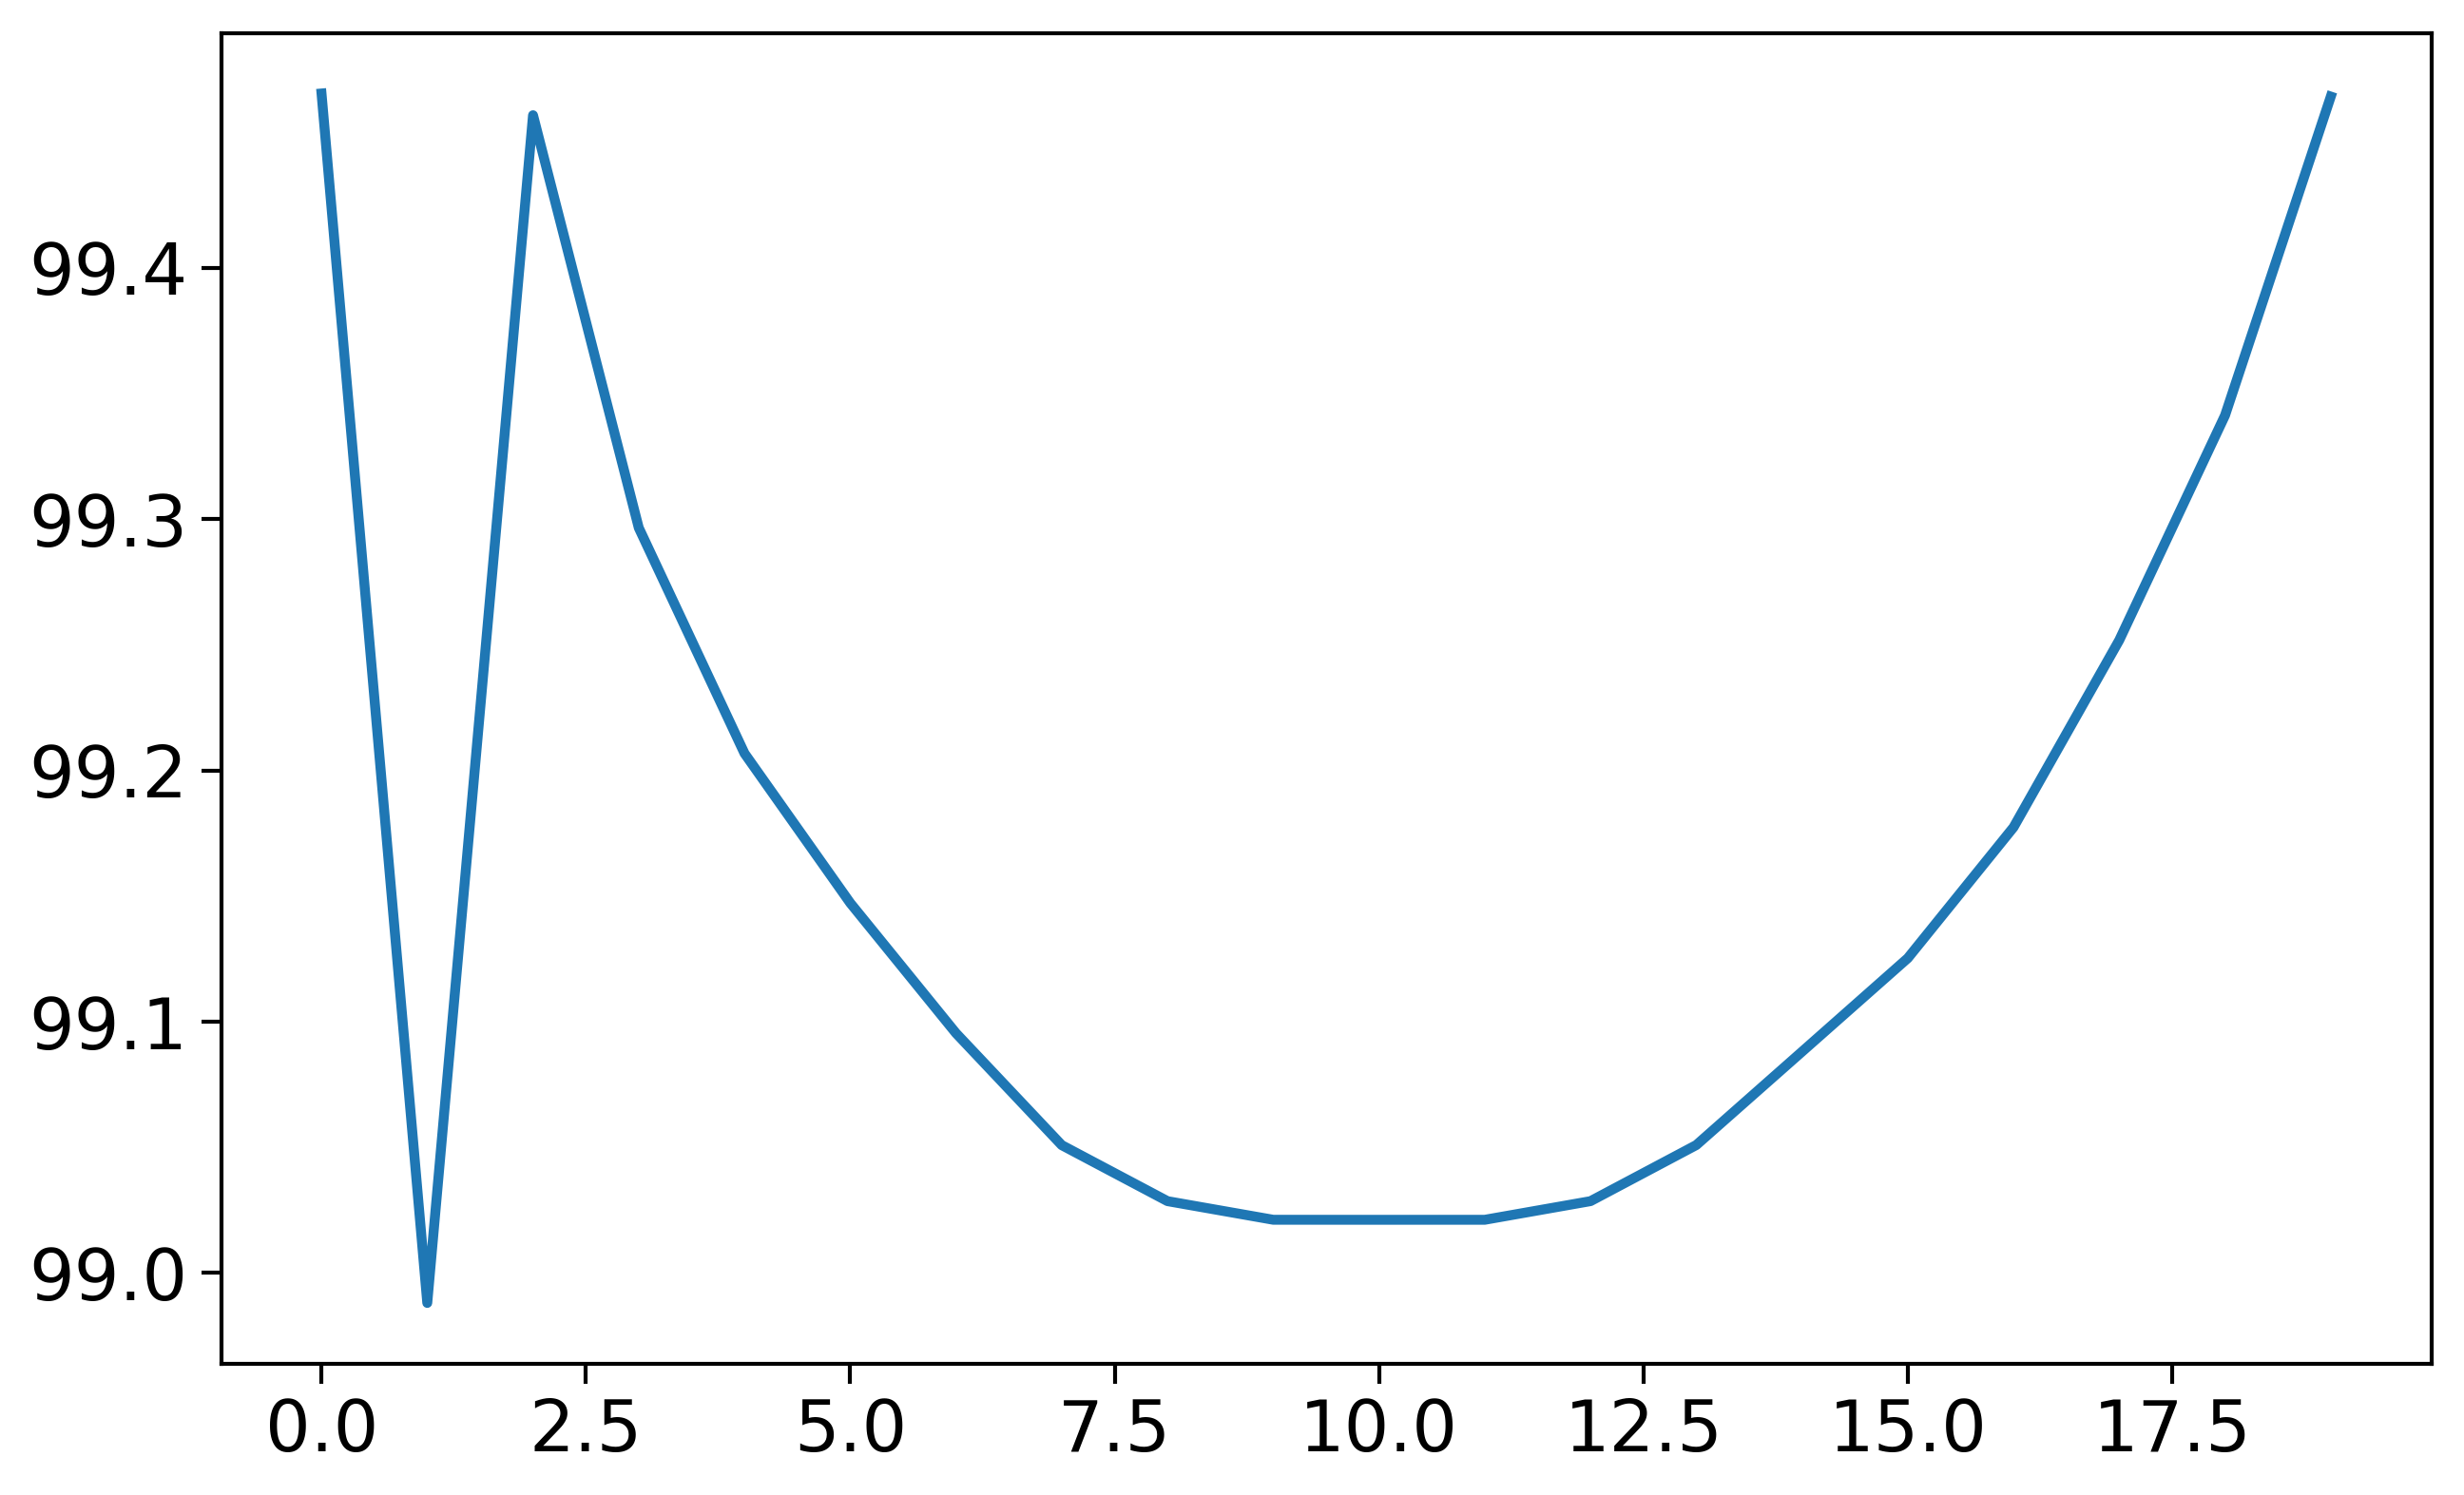

In [203]:
# prepare plot
fidelities_decoh = np.real([100*process_fidelity(to_chi(U_exp[an][-1])/16, to_chi(gates.cphase(an))/16) for an in angles])
plt.plot(fidelities_decoh)

In [201]:
fidelities_decoh

array([99.46928129, 98.98809914, 99.46063542, 99.29649714, 99.20674685,
       99.14722083, 99.09542153, 99.05088107, 99.02860883, 99.02120397,
       99.0211871 , 99.02119719, 99.02861424, 99.05092101, 99.08807621,
       99.12527106, 99.17734642, 99.25179983, 99.34121929, 99.46805436])

In [168]:
100*process_fidelity(to_chi(U[-1])/16, to_chi(gates.cphase(np.pi/2))/16)

(99.99999992510232-1.040834085586084e-15j)

In [218]:
buffers = 0.025
phases = np.arange(0,360, 1)*pi/180
average_gate_length = np.mean(cphi_length(phases, two_qb_gates['qb2qb3'])) + buffers
print("Carb " , average_gate_length )
print("CZ ", 0.107 + buffers)
print('ratio', average_gate_length / (0.107 + buffers))

Carb  0.10973013592466616
CZ  0.132
ratio 0.8312889085201981


# 3 qubits

In [474]:
11*0.0466666 + 2*0.107+ 2*0.094 + 0.015*4 + 0.025*2

1.0253326

In [7]:
alpha_zzs = 2*np.pi*np.array([[0,-0.109,0],[0,0,-0.379],[0,0,0]])
# sim.alpha_zz(alpha_zzs)

In [841]:
1/94e-3 - alpha_zzs[0,1]

10.751297872340425

In [134]:
qubits = ["qb1", "qb2", 'qb3']
freq = {"qb1": 0, "qb2": 0}
t1s = {"qb1": 23, "qb2": 16.4, "qb3": 22}
t2s = {"qb1": 25.6, "qb2": 21, "qb3":25}

# arb_phase_funcs = {"qb1qb2": "lambda phi: (1.9099/106e-3, 106e-3)"}
# arb_phase_funcs = {"qb1qb2": "lambda phi: (1/94e-3 - alpha_zzs[0,1]/pi*124/94, 94e-3)",
#                    "qb2qb3": "lambda phi: (1/107.5e-3 - alpha_zzs[1,2]/pi*132.5/107.5, 107.5e-3)"}
arb_phase_funcs = {"qb1qb2": "lambda phi: (1/98e-3, 98e-3)",
                   "qb2qb3": "lambda phi: (1/107.5e-3, 107.5e-3)"}

single_qb_pulse_length = 0.046666
# psi0 = ket("0"*len(qubits))
psi0 = tensor(thermal_dm(2, 0.008), thermal_dm(2, 0.007), thermal_dm(2, 0.017))
sim = Simulator(qubits)
# sim.alpha_zz(alpha_zzs)
sim.z_gate_length = 0.0001
depth = 1
Cs = [0.5, 1]


# sim.alpha_zz(alpha_zzs)
# init
sim.ry(length=single_qb_pulse_length, angle=pi/2, qubits='all')


# params = dict(g=[1.940897768208033,0.9666844823356445,2.772132044860666,2.309917454663161,3.3445826894178183,1.1224922614360544,2.5426242774323127,3.4136236280179553,-0.16948225188854313,1.9267825683628026], b=[1.77851179850078,2.2033574267981217,1.4819516119903635,4.480386169071666,2.495939695232518,0.07321215272329895,6.294539837569337,2.3051562674962494,2.244969010609862,5.373081388770109])
# params = dict(g=[gg.flatten()[1270]], b=[bb.flatten()[1270]])
# params = dict( g=[0.67848787], b=[ 3.9269908 ])
params = dict( g=[pi/2], b=[ pi/2 ])
for d in range(depth):
    # # U
    software_decomposition("qb1", "qb2", sim, single_qb_pulse_length, angle=Cs[0]*params['g'][d], 
                           arb_phase_func=arb_phase_funcs['qb1qb2'])
    software_decomposition("qb3", "qb2", sim, single_qb_pulse_length, angle=Cs[1]*params['g'][d], 
                           arb_phase_func=arb_phase_funcs['qb2qb3'], buffer_start=0.01)

    # # D
    sim.ry(single_qb_pulse_length, angle=-pi/2, qubits='all')
    sim.rz(sim.z_gate_length, angle=params['b'][d], qubits='all')
    sim.ry(single_qb_pulse_length, angle=pi/2, qubits='all')

time = np.arange(0,sim.get_sequence_length(),0.00001)
print(sim.get_sequence_length(), len(time))

res = mesolve(sim.Ht, psi0, time, [], [], progress_bar=True,
             options=Options(max_step=0.0001, tidy=False))
res.states[-1]

1.035426 103543
10.0%. Run time:   1.03s. Est. time left: 00:00:00:09
20.0%. Run time:   2.00s. Est. time left: 00:00:00:08
30.0%. Run time:   3.06s. Est. time left: 00:00:00:07
40.0%. Run time:   4.08s. Est. time left: 00:00:00:06
50.0%. Run time:   5.13s. Est. time left: 00:00:00:05
60.0%. Run time:   6.17s. Est. time left: 00:00:00:04
70.0%. Run time:   7.25s. Est. time left: 00:00:00:03
80.0%. Run time:   8.26s. Est. time left: 00:00:00:02
90.0%. Run time:   9.31s. Est. time left: 00:00:00:01
Total run time:  10.75s


Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 1.25189286e-01+0.00000000e+00j -1.21058221e-01-3.88373198e-06j
  -4.94698209e-05-1.23042223e-01j  5.13534388e-05+1.18993090e-01j
  -8.52991933e-05+1.23284709e-01j  7.90909108e-05-1.19231155e-01j
  -1.21510079e-01-1.24290416e-04j  1.17526289e-01+1.24066451e-04j]
 [-1.21058221e-01+3.88373198e-06j  1.25158466e-01+0.00000000e+00j
   5.15311610e-05+1.18981407e-01j -5.68952088e-05-1.23022752e-01j
   7.88956791e-05-1.19215365e-01j -7.80743101e-05+1.23269649e-01j
   1.17498677e-01+1.16298277e-04j -1.21506393e-01-1.24249514e-04j]
 [-4.94698209e-05+1.23042223e-01j  5.15311610e-05-1.18981407e-01j
   1.24827597e-01+0.00000000e+00j -1.20719569e-01+3.68118740e-06j
  -1.21160603e-01-1.34894708e-04j  1.17176770e-01+1.26770242e-04j
   1.69843300e-04-1.23273179e-01j -1.67826370e-04+1.19230962e-01j]
 [ 5.13534388e-05-1.18993090e-01j -5.68952088e-05+1.23022752e-01j
  -1.20719569e-01-3.68118740e-06j  1.

## Simulate at optimal parameters

In [25]:
# define optimal parameters and problem
Cs = [0.5, 1]
correct_states = ((1,0,1), (0,1,0))
optimal_params={
    1:dict(g=[0.67848787], b=[3.9269908]),
    2: dict(g=[0.64186931,1.15633934], b=[1.08778431,0.56831448]),
    3: dict(g=[ 0.91293813,  1.38149213,  2.64575812], b=[4.25592023,  6.8627972,  -0.47658777]),
    4: dict(g= [0.79047109, 1.29788154, 2.65529822, 1.02307546 ], b=[ 0.9663438, 3.66163585, 5.75941282 ,6.01503621]),
    5: dict(g = [0.62732382, 0.00640932, 1.21334409, 0.32948633, 1.03519245], b=[0.21928593 ,1.03185706, 0.84183517, 3.16511823, 3.56522479] ),
    6: dict(g=[1.03885048, 1.35146962, 2.06623968, 2.43631484, 3.12286653, 2.84845525], 
            b=[5.16561146, 4.02608211, 5.61752595, 6.82999765, 0.340696,   0.93796757]),
    7: dict(g=[ 1.13027127,  2.39374872, -0.35931365,  3.47810144,  1.62313939 , 0.16434764, 0.75164923], b=[  1.60770037,  2.89058529 , 1.63604546 , 1.33216744 , 1.46064182, 5.68443475,  3.85156408] ),
    8: dict(g=[1.055365503442032,1.3098777325119684,1.7014313196688995,1.147763909186312,0.6952683724838693,2.4871574459657615,2.162997348460366,2.368623128268789], b=[6.700351002594094,2.750288054308348,1.8334785312398794,1.4997245667843095,3.973993966376086,3.124898728718041,5.88391836689478,5.80487108919712]),
    9: dict(g=[2.255384671867681,1.1263556452930128,2.3564798544033287,0.4540511845994959,0.45683699857291366,0.42311647779005124,2.6114716195550667,0.7300887629608801,1.9252202179959783], b=[4.099035024586171,1.1189046530120206,2.6440433383427684,0.3914697152007607,3.797694667114474,0.47789898540596154,4.662660755443585,2.370377288094952,2.4849199081896343]),
    10:dict(g=[1.940897768208033,0.9666844823356445,2.772132044860666,2.309917454663161,3.3445826894178183,1.1224922614360544,2.5426242774323127,3.4136236280179553,-0.16948225188854313,1.9267825683628026], b=[1.77851179850078,2.2033574267981217,1.4819516119903635,4.480386169071666,2.495939695232518,0.07321215272329895,6.294539837569337,2.3051562674962494,2.244969010609862,5.373081388770109])}


In [29]:
qubits = ["qb1", "qb2", 'qb3']
freq = {"qb1": 0, "qb2": 0}
t1s = {"qb1": 23, "qb2": 16.4, "qb3": 22}
t2s = {"qb1": 25.6, "qb2": 21, "qb3":25}

# arb_phase_funcs = {"qb1qb2": "lambda phi: (1.9099/106e-3, 106e-3)"}
# arb_phase_funcs = {"qb1qb2": "lambda phi: (1/94e-3 - alpha_zzs[0,1]/pi*124/94, 94e-3)",
#                    "qb2qb3": "lambda phi: (1/107.5e-3 - alpha_zzs[1,2]/pi*132.5/107.5, 107.5e-3)"}
arb_phase_funcs = {"qb1qb2": "lambda phi: (1/98e-3, 98e-3)",
                   "qb2qb3": "lambda phi: (1/107.5e-3, 107.5e-3)"}

single_qb_pulse_length = 0.046666

# psi0 = ket("0"*len(qubits))
psi0 = tensor(thermal_dm(2, 0.008), thermal_dm(2, 0.007), thermal_dm(2, 0.017))
results = []

for params in optimal_params.values():
    sim = Simulator(qubits)
    sim.z_gate_length = 0.0001
#     sim.alpha_zz(alpha_zzs)

    # init
    sim.ry(length=single_qb_pulse_length, angle=pi/2, qubits='all')

    for g,b in zip(params['g'], params['b']):
        # # U
        software_decomposition("qb1", "qb2", sim, single_qb_pulse_length, angle=Cs[0]*g, 
                               arb_phase_func=arb_phase_funcs['qb1qb2'])
        software_decomposition("qb3", "qb2", sim, single_qb_pulse_length, angle=Cs[1]*g, 
                               arb_phase_func=arb_phase_funcs['qb2qb3'], buffer_start=0.01)

        # # D
        sim.ry(single_qb_pulse_length, angle=-pi/2, qubits='all')
        sim.rz(sim.z_gate_length, angle=b, qubits='all')
        sim.ry(single_qb_pulse_length, angle=pi/2, qubits='all')

    time = np.arange(0,sim.get_sequence_length(),0.00005)
    print(sim.get_sequence_length(), len(time))

    res = mesolve(sim.Ht, psi0, time, sim.collapse(t1s, t2s), [], progress_bar=True,
                 options=Options(max_step=0.0001, tidy=False))
    results.append(res)

1.035426 20709
10.0%. Run time:   0.44s. Est. time left: 00:00:00:03
20.0%. Run time:   0.84s. Est. time left: 00:00:00:03
30.0%. Run time:   1.31s. Est. time left: 00:00:00:03
40.0%. Run time:   1.93s. Est. time left: 00:00:00:02
50.0%. Run time:   2.41s. Est. time left: 00:00:00:02
60.0%. Run time:   2.85s. Est. time left: 00:00:00:01
70.0%. Run time:   3.37s. Est. time left: 00:00:00:01
80.0%. Run time:   3.78s. Est. time left: 00:00:00:00
90.0%. Run time:   4.23s. Est. time left: 00:00:00:00
Total run time:   4.69s
2.0241860000000003 40484
10.0%. Run time:   1.18s. Est. time left: 00:00:00:10
20.0%. Run time:   2.44s. Est. time left: 00:00:00:09
30.0%. Run time:   3.72s. Est. time left: 00:00:00:08
40.0%. Run time:   5.04s. Est. time left: 00:00:00:07
50.0%. Run time:   6.42s. Est. time left: 00:00:00:06
60.0%. Run time:   7.88s. Est. time left: 00:00:00:05
70.0%. Run time:   9.25s. Est. time left: 00:00:00:03
80.0%. Run time:  10.61s. Est. time left: 00:00:00:02
90.0%. Run time:  

KeyboardInterrupt: 

In [30]:
# readout correction and compute success prob
ro_mtx = {"qb1": renormalize(np.array([[0.997,0.0015],[0.0207, 0.9790]])), 
          "qb2": renormalize(np.array([[0.998,0.0015],[0.0202, 0.9689]])), 
          "qb3": renormalize(np.array([[0.992, 0.0043],[0.0177,0.97921]]))}
state_probs = []
success_probs_me_dec = []
for rho in  [r.states[-1] for r in results]:
    _, zz, state_prob, _, _ = readout_correction(sim, ro_mtx, rho=rho)
    state_probs.append(state_prob)
    success_probs_me_dec.append(np.sum([state_prob[c] for c in correct_states]))

In [31]:
# no alpha zz
success_probs_me_dec

[0.5895279281716093,
 0.7709312924554252,
 0.8011564042064074,
 0.7493480880858692,
 0.7232543402264557,
 0.6617557212963893,
 0.6603480932624091,
 0.5861468773322062]

In [11]:
success_probs_me_dec

[0.5583162519402016,
 0.7298898176065779,
 0.5628211340936882,
 0.5549802287641488,
 0.28315563510471575,
 0.15616239926193265,
 0.3278036037560843,
 0.372550089513358,
 0.3607973665952706]

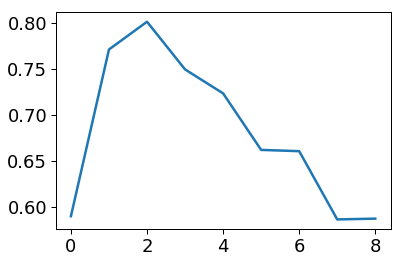

In [147]:
plt.plot(success_probs_me_dec)

In [135]:
#  calculate correlation

rho = res.states[-1]
corr = []
for k, op in zip(range(2), (0.5*sim.sz("qb1")*1*sim.sz("qb2"), 1*sim.sz("qb2")*1*sim.sz("qb3"))):
    corr.append(expect(op, rho))
print(corr)

[0.0007001255448143145, 4.603805340594458e-05]


In [28]:
import datetime as dt
# simulate landscape
qubits = ["qb1", "qb2", "qb3"]
n_points = 10
Cs = [0.5,1]
step_size = 0.00005
gammas = np.linspace(0,np.pi, n_points)
betas = np.linspace(0,np.pi, n_points)

# create two d space
gg, bb = np.meshgrid(gammas, betas)
states = np.zeros_like(gg, dtype=object)

# collapse
t1s = {"qb1": 22.86, "qb2": 16.4, "qb3": 15}
t2s = {"qb1": 25.6, "qb2": 21.5, "qb3": 15.2}

# arb_phase_funcs = {"qb1qb2": "lambda phi: (1.9099/106e-3, 106e-3)"}
arb_phase_funcs = {"qb1qb2": "lambda phi: (1/96e-3, 96e-3)",
                   "qb2qb3": "lambda phi: (1/107e-3, 107e-3)"}

single_qb_pulse_length = 0.046666
# psi0 = ket("0"*len(qubits))
psi0 = tensor(thermal_dm(2, 0.01), thermal_dm(2, 0.01), thermal_dm(2, 0.015))
depth = 1
for i in range(n_points):
    print(i, dt.datetime.now())
    for j in range(n_points):
        sim = Simulator(qubits)
        sim.z_gate_length = 0.0001
        g = gg[i,j]
        b = bb[i,j]
        # init
        sim.ry(length=single_qb_pulse_length, angle=pi/2, qubits='all')

        for d in range(depth):
            # # U
            software_decomposition("qb1", "qb2", sim, single_qb_pulse_length, 
                                   angle=Cs[0]*g, arb_phase_func=arb_phase_funcs['qb1qb2'])
            software_decomposition("qb3", "qb2", sim, single_qb_pulse_length, 
                                   angle=Cs[1]*g, arb_phase_func=arb_phase_funcs['qb2qb3'])

            # # D
            sim.ry(single_qb_pulse_length, angle=-pi/2, qubits='all')
            sim.rz(sim.z_gate_length, angle=b, qubits='all')
            sim.ry(single_qb_pulse_length, angle=pi/2, qubits='all')

        time = np.linspace(0,sim.get_sequence_length(), 50)
        print(sim.get_sequence_length())
        res = mesolve(sim.Ht, psi0, time, sim.collapse(t1s, t2s), [], 
                      options=Options(max_step=step_size))
        states[i,j] = res.states[-1]

0 2020-02-06 15:10:14.906000
1.0404259999999999
1.0404259999999999
1.0404259999999999


KeyboardInterrupt: 

In [22]:
corr = {i: np.zeros_like(gg) for i in range(2)}
for k, op in zip(range(2), (sim.sz("qb1")*sim.sz("qb2"), sim.sz("qb2")*sim.sz("qb3"))):
    for i in range(n_points):
        for j in range(n_points):
            corr[k][i,j] = expect(op, states[i,j])
energy = np.zeros_like(gg)

# sum all correlations in Ising model
for pair, C in zip(corr, Cs):
    energy +=  C*corr[pair]
# for qb, h in zip(range(n_qbs), hs):
#     energy += h * single_qb_term[qb]

In [23]:
energy.min()

-0.9614116198091293

Text(0, 0.5, '$\\beta$ (rad.)')

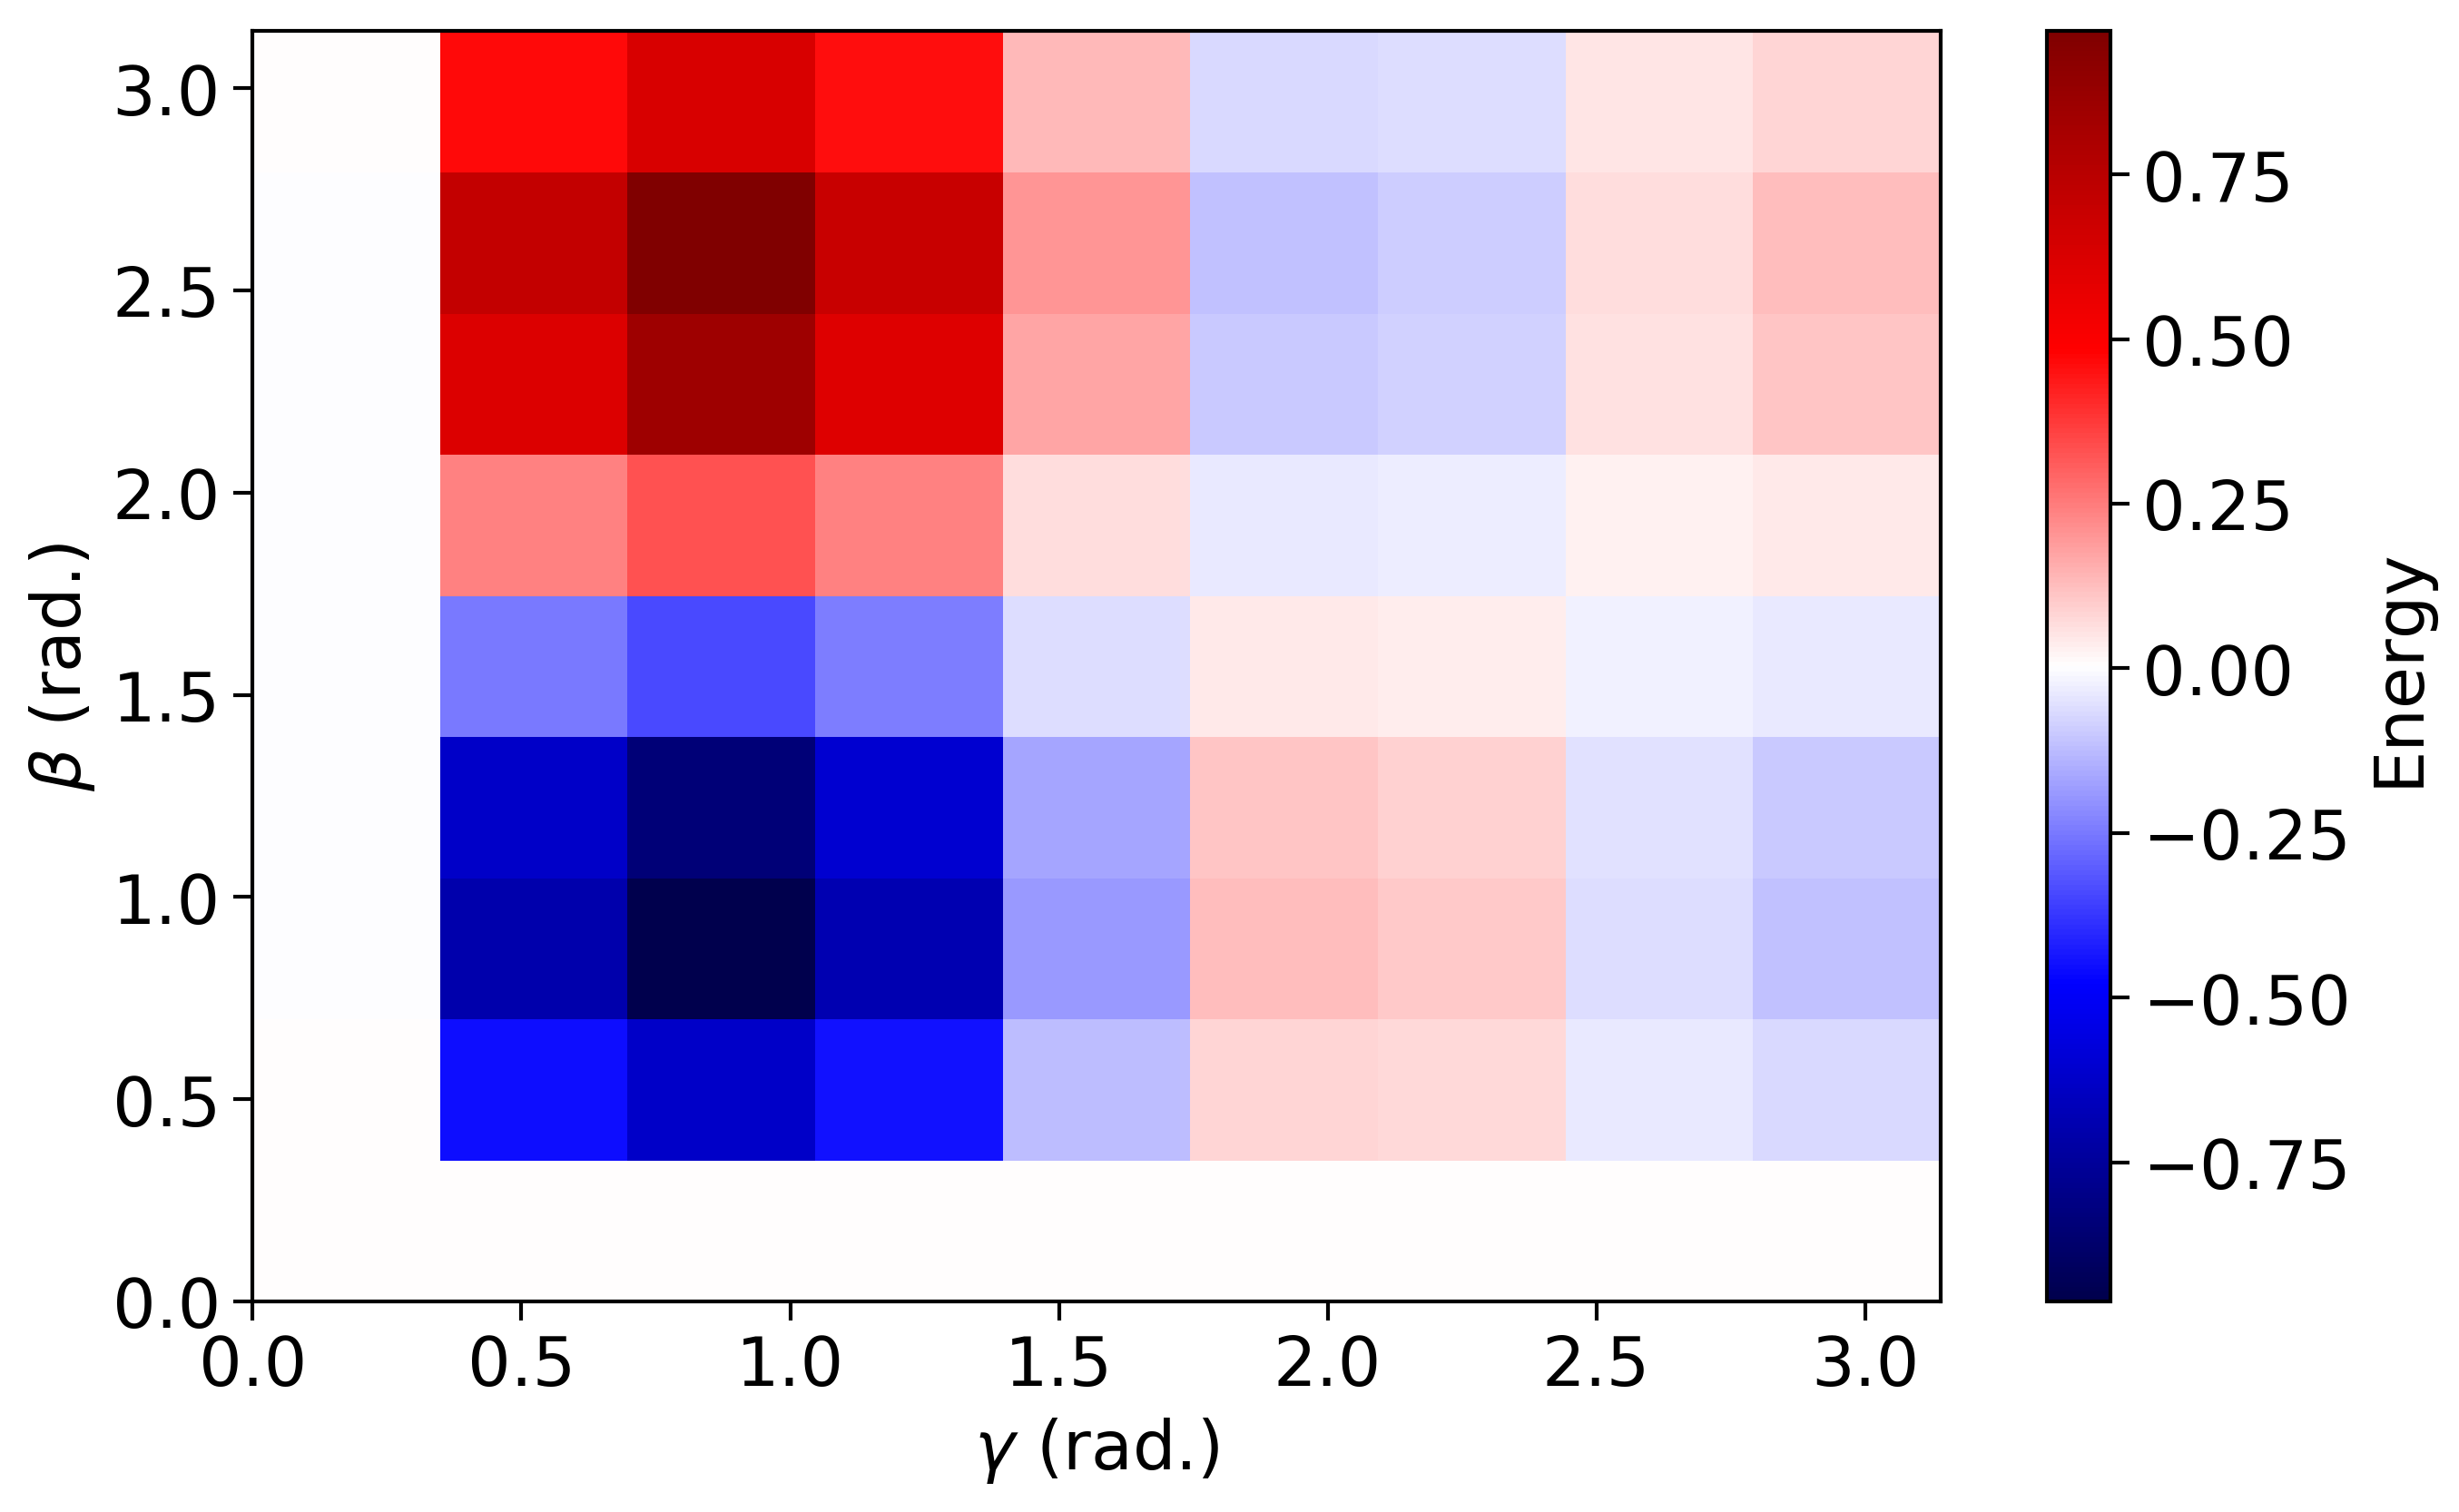

In [24]:
fig, ax = plt.subplots()
im = ax.pcolormesh(gg, bb, energy, cmap="seismic")
cb = fig.colorbar(im)
cb.set_label("Energy")
ax.set_xlabel("$\gamma$ (rad.)")
ax.set_ylabel("$\\beta$ (rad.)")


# Bar plot

In [13]:
from pycqed.measurement import qaoa
import itertools

In [657]:
%matplotlib notebook

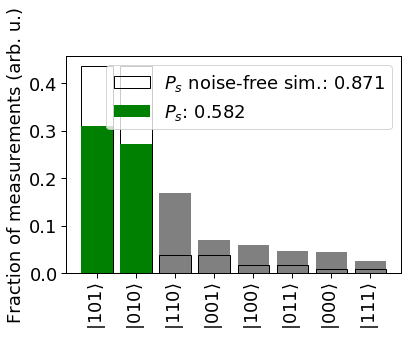

In [14]:
t = "20191218_173938"
r = bar_plot(t,correct_states=["101","010"], save=False)

In [9]:
print(zz)
state_prob

{(0, 1): -0.32619181428010574, (0, 2): 0.2503986040356543, (1, 2): -0.7776346793071602}


{(0, 0, 0): 0.023171183848780665,
 (0, 0, 1): 0.16080384051598934,
 (0, 1, 0): 0.2950713090222274,
 (0, 1, 1): 0.03555070658545248,
 (1, 0, 0): 0.038988926148870104,
 (1, 0, 1): 0.2934849653835024,
 (1, 1, 0): 0.13945722473186037,
 (1, 1, 1): 0.013471843763316182}

In [831]:
print(-0.3269 + 0.2582)
print(-0.7504 + 0.6823)

-0.06870000000000004
-0.06809999999999994


<BarContainer object of 8 artists>

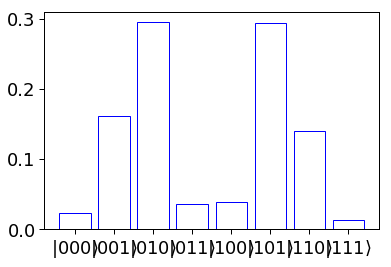

In [15]:
correct_states_indices = [2,5]
sim_fid = np.real(np.sum(np.array(list(state_prob.values()))[correct_states_indices]))
plt.bar(r["expected_state_labels"] , state_prob.values(), 
               fill=False, linewidth=1, edgecolor='b', 
               label="$P_s$  sim. ro + zz: {:.3f}".format(sim_fid))

c:\users\nathan\masterthesis\code\env\lib\site-packages\matplotlib\transforms.py:827: ComplexWarning:

Casting complex values to real discards the imaginary part



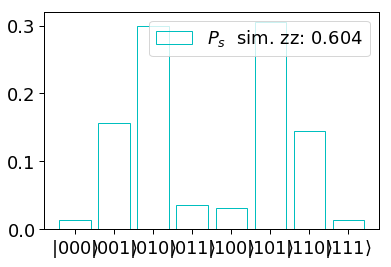

In [16]:
rho = res.states[-1]
correct_states_indices = [2,5]

# readout correction


sim_fid = np.real(np.sum(np.diag(rho.full())[correct_states_indices]))
plt.bar(r["expected_state_labels"] , np.diag(rho.full()), 
               fill=False, linewidth=1, edgecolor='c', 
               label="$P_s$  sim. zz: {:.3f}".format(sim_fid))
plt.legend()

In [494]:
import os
import time
        
def save(self, *arrays, names=None, directory=None):
    localtime = time.localtime()
    timestamp = time.asctime(localtime)
    timemark = time.strftime('%H%M%S', localtime)
    datemark = time.strftime('%Y%m%d', localtime)
    if directory is None:
        directory = "simulation_output"
    try:
        os.makedirs(directory)
    except FileExistsError:
        pass
    try:
        os.makedirs(os.path.join(directory,datemark))
    except FileExistsError:
        pass
    try:
        os.makedirs(os.path.join(directory,datemark, timemark))
    except FileExistsError:
        pass
    
    if names is None:
        names = [f'array_{i}' for i in range(len(arrays))]

    for array, name in zip(arrays, names):
        filepath = os.path.join(directory, datemark, timemark, f"{name}.npy")
        print(f"Saving {name} to {filepath}")
        np.save(filepath, array)
        
def load(self, directory=None, timestamp=None, path=None):
    arrays = {}
    if path is None:
        raise NotImplementedError()
    for r, d, f in os.walk(path):
        for file in f:
            arrays[file.split('.npy')[0]] = np.load(os.path.join(r, file), allow_pickle=True)
    return arrays

In [ ]:
# visualize simulation

In [ ]:
params = dict(qubits = ["qb1", "qb2", "qb3"], Cs = [0.5,1], t1s = {"qb1": 22.86, "qb2": 16.4, "qb3": 22.7},
              t2s = {"qb1": 25.6, "qb2": 21.5, "qb3": 25.2})

In [346]:
save(None, gg, bb, energy, states, [params], names=['gammas','betas', 'energy', 'states', 'params'])

Saving gammas to simulation_output\20191212\145226\gammas.npy
Saving betas to simulation_output\20191212\145226\betas.npy
Saving energy to simulation_output\20191212\145226\energy.npy
Saving states to simulation_output\20191212\145226\states.npy
Saving params to simulation_output\20191212\145226\params.npy


In [1059]:
q = QubitCircuit(2)
# q.add_gate("RZ", targets=0, arg_value=pi)
# q.add_gate("RZ", targets=1, arg_value=pi)

# q.add_gate("RY", targets=0, arg_value=pi/2)
# q.add_gate("RY", targets=1, arg_value=pi/2)

# q.add_gate("RZ", targets=0, arg_value=pi)
# q.add_gate("RZ", targets=1, arg_value=pi)

# q.add_gate("RY", targets=0, arg_value=pi/2)
# q.add_gate("RY", targets=1, arg_value=pi/2)

# q.add_gate("RZ", targets=0, arg_value=pi)
# q.add_gate("RZ", targets=1, arg_value=pi)

# q.add_gate("RY", targets=0, arg_value=pi/2)
# q.add_gate("RY", targets=1, arg_value=pi/2)

q.add_gate("RY", targets=0, arg_value=pi/2)
q.add_gate("RY", targets=1, arg_value=pi/2)

q.add_gate("RZ", targets=1, arg_value=pi)
q.add_gate("RY", targets=1, arg_value=pi/2)
q.add_gate('CPHASE', targets=1, controls=0, arg_value=pi)
q.add_gate("RZ", targets=1, arg_value=pi)
q.add_gate("RY", targets=1, arg_value=pi/2)
q.add_gate("RZ", targets=1, arg_value=-2*gamma*C)
q.add_gate("RZ", targets=1, arg_value=np.pi)
q.add_gate("RY", targets=1, arg_value=np.pi/2)
q.add_gate("CPHASE", controls=0, targets=1, arg_value=np.pi)

q.add_gate("RZ", targets=1, arg_value=np.pi)
q.add_gate("RY", targets=1, arg_value=np.pi/2)

q.add_gate("RX", targets=0, arg_value=beta)
q.add_gate("RX", targets=1, arg_value=beta)
gate_sequence_product(q.propagators()) *ket("00")
# expect(sim.sz('qb1')*sim.sz('qb2'), gate_sequence_product(q.propagators()) *ket("00"))

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0. +0.j ]
 [0.5-0.5j]
 [0.5-0.5j]
 [0. +0.j ]]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.08610154e-09+0.00000000e+00j  0.00000000e+00-3.41225383e-08j
   0.00000000e+00+9.26783933e-11j  6.01443146e-10+0.00000000e+00j]
 [ 0.00000000e+00+3.41225383e-08j  4.97955206e-01+0.00000000e+00j
  -6.01443146e-10+0.00000000e+00j  0.00000000e+00-3.67011772e-10j]
 [ 0.00000000e+00-9.26783933e-11j -6.01443146e-10+0.00000000e+00j
  -1.16641902e-10+0.00000000e+00j  0.00000000e+00-3.45822284e-08j]
 [ 6.01443146e-10+0.00000000e+00j  0.00000000e+00+3.67011772e-10j
   0.00000000e+00+3.45822284e-08j  5.02044793e-01+0.00000000e+00j]]

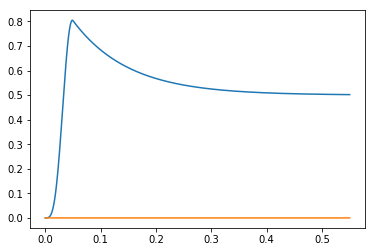

In [35]:
plt.plot(time, [np.real(r.full()[3,3]) for r in res.states])
plt.plot(time, [np.imag(r.full()[3,3]) for r in res.states])

# plt.plot(time, [np.real(r.full()[1]) for r in res.states])
# plt.plot(time, [np.imag(r.full()[1]) for r in res.states])


# plt.plot(time, [np.real(r.full()[2]) for r in res.states])
# plt.plot(time, [np.imag(r.full()[2]) for r in res.states])

# plt.plot(time, [np.real(r.full()[3]) for r in res.states])
# plt.plot(time, [np.imag(r.full()[3]) for r in res.states])

res.states[-1]


In [545]:
cphase = []
phase00 = []
phase01 = []
phase10 = []
cphase_ampl = np.linspace(0,2,50)
for amp in cphase_ampl:
    arb_phase_funcs = {"qb1qb2": f"lambda phi: (1*{amp}/100e-3, 100e-3)"}
    
    psi0 = ket("0"*len(qubits))
    sim = SimulationHelper(qubits)

    sim.rotation_y(length=single_qb_pulse_length, angle=pi/2, qubits='all')

    # Hs = sim.rotation_x(amplitude)
    Hcphi = sim.Cphi(["qb1", "qb2"],arb_phase_funcs['qb1qb2'],  pi, single_qb_pulse_length, )
#     Hq = sim.rotation_z(freq)

    Ht = [ Hcphi ]

    res = mesolve(Ht, psi0, time, [], [], args=single_qb_pulses)
    cphase.append(np.angle(res.states[-1].full()[-1]))
    phase00.append(np.angle(res.states[-1].full()[0]))
    phase01.append(np.angle(res.states[-1].full()[1]))
    phase10.append(np.angle(res.states[-1].full()[2]))

